=== BASE CASE ===
N = 8
Omega/2pi = 1.414 MHz
t_swap = pi/Omega = 0.3536 µs
B0_res (T) = -0.003889
t_on = 0.200 µs
B_det = 0.300 T  (detuning/Ω ~ 96.7)


c:\git\sq\.venv\Lib\site-packages\qutip\solver\options.py:7: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


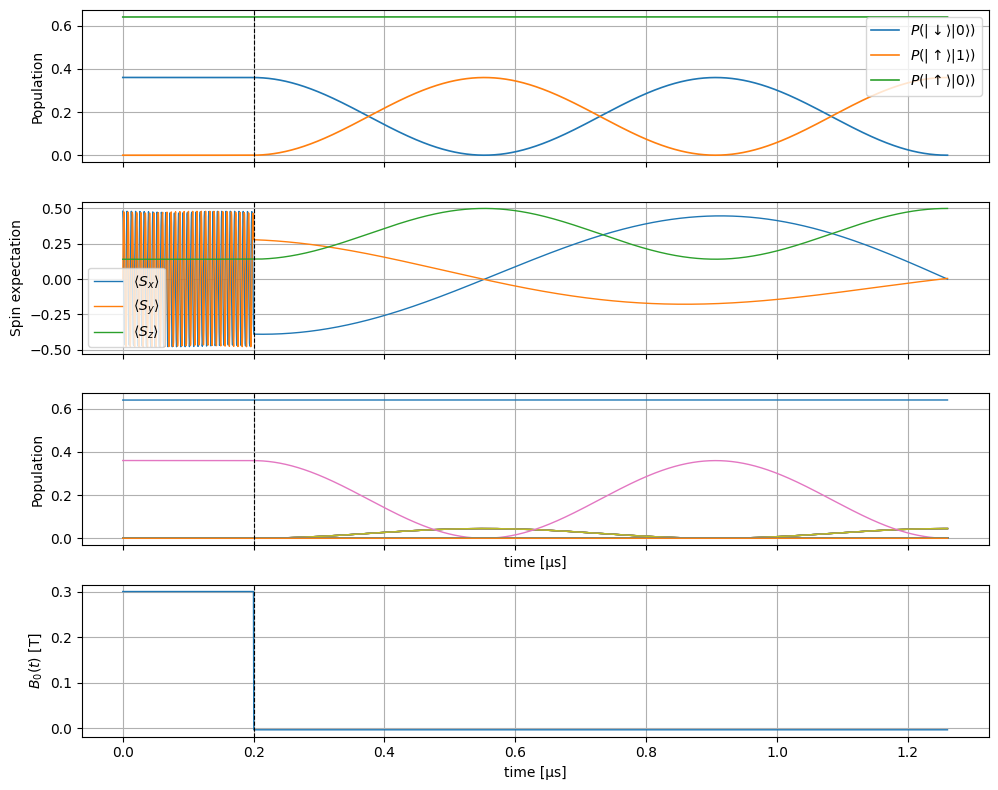

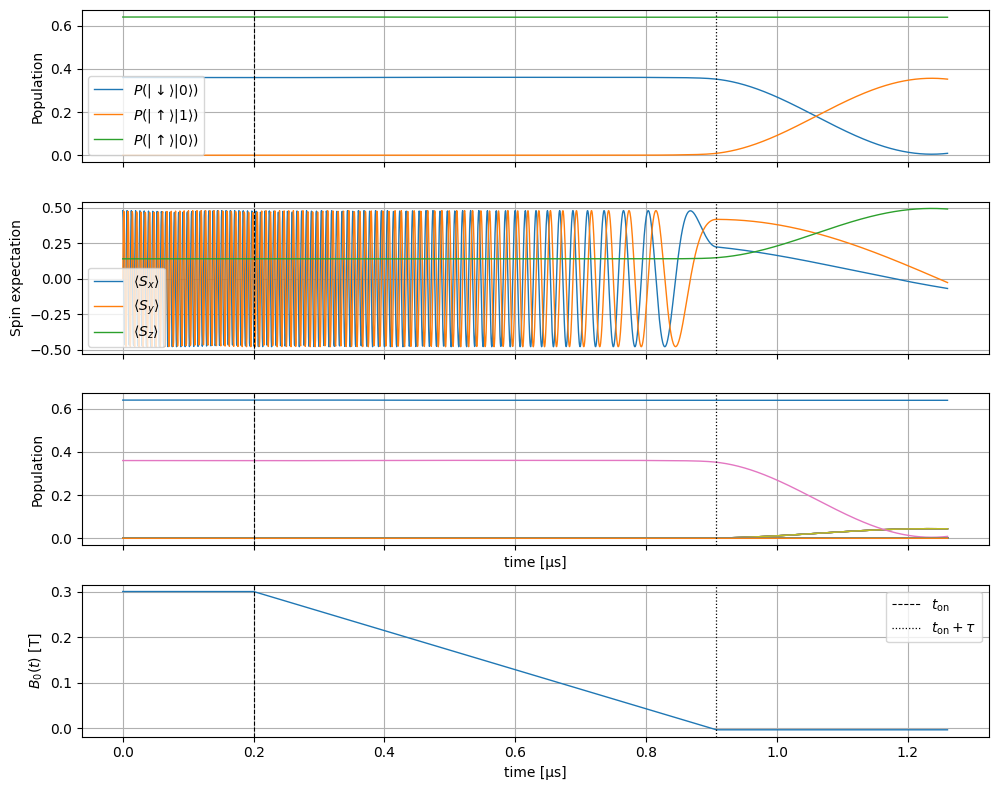

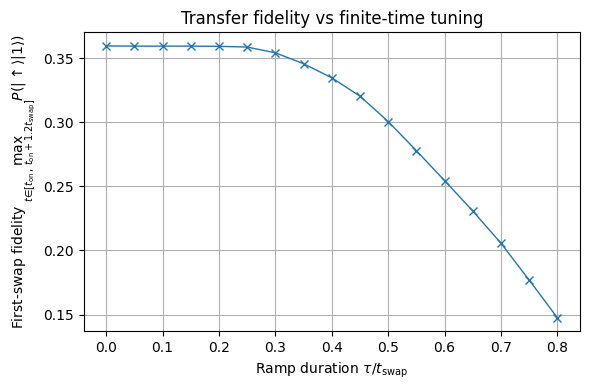

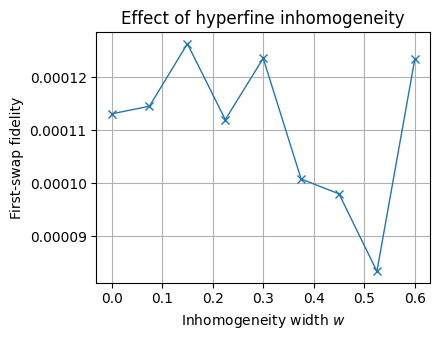

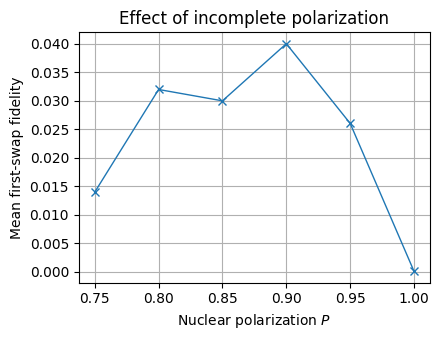


Saved:
  fig1_step_benchmark.png
  fig2_linear_ramp.png
  fig3_fidelity_vs_tau.png
  fig4a_inhomogeneity.png
  fig4b_incomplete_polarization.png


In [ ]:
# ============================================================================
# Quantum Memory (Taylor-style) — Consistent Figure Generator (4 figures)
# Electron + N nuclear spins (spin-1/2), ħ = 1, angular-frequency units.
#
# FIG 1: Step-to-resonance benchmark (detuned -> resonant and hold)
# FIG 2: Linear ramp-to-resonance (detuned -> ramp -> resonant and hold)
# FIG 3: Fidelity vs ramp time tau (homogeneous, fully polarized)
# FIG 4: Extensions: (a) inhomogeneity sweep, (b) incomplete polarization sweep
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import qutip
from qutip import SolverOptions

np.random.seed(0)

# ----------------------------
# Global numerical settings
# ----------------------------
MHz = 1e6
N_NUC = 8
N_float = float(N_NUC)
tau_example_factor = 0.8

# Output names
FIG1 = "fig1_step_benchmark.png"
FIG2 = "fig2_linear_ramp.png"
FIG3 = "fig3_fidelity_vs_tau.png"
FIG4A = "fig4a_inhomogeneity.png"
FIG4B = "fig4b_incomplete_polarization.png"
dpi = 400

# ----------------------------
# Calibrated Zeeman couplings (rad/s/T)
# (chosen to set frequency hierarchy, not material-accurate)
# ----------------------------
gmuB   = 2*np.pi*50e6 / 0.1     # electron Zeeman ~ 50 MHz at 0.1 T
gnumun = 2*np.pi*5e6  / 0.1     # nuclear  Zeeman ~ 5  MHz at 0.1 T

# ----------------------------
# Hyperfine couplings
# ----------------------------
a_mean = 2*np.pi*0.5*MHz        # per nucleus (homogeneous default)

# ============================================================================
# Operators
# ============================================================================
sx, sy, sz = 0.5*qutip.sigmax(), 0.5*qutip.sigmay(), 0.5*qutip.sigmaz()
sp, sm = qutip.sigmap(), qutip.sigmam()

def e(op):
    return qutip.tensor([op] + [qutip.qeye(2) for _ in range(N_NUC)])

def n(op, k):
    ops = [qutip.qeye(2)]*(1+N_NUC)
    ops[k+1] = op
    return qutip.tensor(ops)

# ============================================================================
# Build Hamiltonian pieces for a given set of couplings a_list
# ============================================================================
def build_hamiltonians(a_list):
    # Zeeman operator multiplied by B0(t)
    H_B = gmuB*e(sz) + gnumun*sum(n(sz,k) for k in range(N_NUC))

    # Hyperfine: V_D + V_Omega (with correct 1/2 in flip-flop)
    H_D = sum(a_list[k]*e(sz)*n(sz,k) for k in range(N_NUC))
    H_O = sum(0.5*a_list[k]*(e(sp)*n(sm,k) + e(sm)*n(sp,k)) for k in range(N_NUC))
    H_hf = H_D + H_O

    Omega = np.sqrt(np.sum(a_list**2))
    A_total = np.sum(a_list)

    # Resonance field for spin-1/2, homogeneous derivation uses A_total:
    B0_res = - (0.5*A_total*(1 - 1/N_float)) / (gmuB - gnumun)

    return H_hf, H_B, Omega, A_total, B0_res

# ============================================================================
# Collective bright state |1>_n and initial/target states
# ============================================================================
def build_states(a_list):
    up, down = qutip.basis(2,0), qutip.basis(2,1)

    # electron superposition
    alpha, beta = 0.8, 0.6
    alpha, beta = alpha/np.sqrt(alpha**2+beta**2), beta/np.sqrt(alpha**2+beta**2)

    n0 = qutip.tensor([up]*N_NUC)
    psi0 = qutip.tensor(alpha*up + beta*down, n0)

    # bright |1>_n weighted by a_j
    Omega = np.sqrt(np.sum(a_list**2))
    single_flip = []
    for k in range(N_NUC):
        cfg = [up]*N_NUC
        cfg[k] = down
        single_flip.append(qutip.tensor(cfg))
    n1 = sum(a_list[k]*single_flip[k] for k in range(N_NUC)) / Omega

    phi_initial = qutip.tensor(down, n0)    # |↓>|0>
    phi_target  = qutip.tensor(up, n1)      # |↑>|1>
    phi_up0     = qutip.tensor(up, n0)      # |↑>|0>

    return psi0, phi_initial, phi_target, phi_up0

# ============================================================================
# Control profiles: detuned until t_on, then (step/ramp) to B_res and hold
# ============================================================================
def B0_step_hold(t, args):
    # detuned until t_on, then instantly to B_res and stay
    return args["B_det"] if t < args["t_on"] else args["B_res"]

def B0_linear_hold(t, args):
    # detuned until t_on, then linear ramp of duration tau to B_res, then hold
    t_on = args["t_on"]
    tau  = args["tau"]
    B_det, B_res = args["B_det"], args["B_res"]

    if t < t_on:
        return B_det
    if tau <= 0:
        return B_res
    if t < t_on + tau:
        return B_det + (B_res - B_det)*(t - t_on)/tau
    return B_res

# Detuning function from derived expression (homogeneous, fully polarized baseline)
def delta_of_B(B, A_total):
    return (gmuB - gnumun)*B + 0.5*A_total*(1 - 1/N_float)

def B_trace_from_profile(B0_fun, args, tgrid):
    return np.array([B0_fun(t, args) for t in tgrid])

# ============================================================================
# Simulation helper
# ============================================================================
def simulate(H_hf, H_B, psi0, tgrid, B0_fun, B0_args,
             phi_initial=None, phi_target=None, phi_up0=None,
             store_states=False):
    """
    Returns dict with requested observables.
    If store_states=True, includes basis populations (expensive).
    """
    H = [H_hf, [H_B, B0_fun]]

    # Projectors for fast expectations
    e_ops = []
    labels = []

    if phi_initial is not None:
        P_i = phi_initial*phi_initial.dag()
        e_ops.append(P_i); labels.append("P_i")
    if phi_target is not None:
        P_f = phi_target*phi_target.dag()
        e_ops.append(P_f); labels.append("P_f")
    if phi_up0 is not None:
        P_up0 = phi_up0*phi_up0.dag()
        e_ops.append(P_up0); labels.append("P_up0")

    # electron spin expectations
    e_ops += [e(sx), e(sy), e(sz)]
    labels += ["Sx","Sy","Sz"]

    opts = SolverOptions(store_states=store_states)

    res = qutip.sesolve(
        H, psi0, tgrid,
        e_ops=e_ops,
        args=B0_args,
        options=opts
    )

    out = {"tgrid": tgrid}
    for idx, name in enumerate(labels):
        out[name] = np.array(res.expect[idx])

    if store_states:
        out["states"] = res.states

    return out

# ============================================================================
# BASE SYSTEM (homogeneous, fully polarized)
# ============================================================================
a_list_base = np.array([a_mean]*N_NUC)
H_hf_base, H_B_base, Omega_base, A_total_base, B0_res_base = build_hamiltonians(a_list_base)
psi0_base, phi_i_base, phi_f_base, phi_up0_base = build_states(a_list_base)

t_swap = np.pi / Omega_base

# Choose an "experimental-looking" turn-on time
t_on = 0.2e-6  # 0.2 microseconds (as you suggested)
# Simulate long enough to see several oscillations AFTER turning on
tmax = t_on + 3.0*t_swap
tgrid = np.linspace(0, tmax, 2500)

# Detuned field chosen so |delta| >> Omega (suppress exchange)
B_det = 0.3

print("=== BASE CASE ===")
print(f"N = {N_NUC}")
print(f"Omega/2pi = {Omega_base/(2*np.pi)/1e6:.3f} MHz")
print(f"t_swap = pi/Omega = {t_swap*1e6:.4f} µs")
print(f"B0_res (T) = {B0_res_base:.6f}")
print(f"t_on = {t_on*1e6:.3f} µs")
print(f"B_det = {B_det:.3f} T  (detuning/Ω ~ {abs(delta_of_B(B_det,A_total_base))/Omega_base:.1f})")

# ============================================================================
# FIGURE 1: Step benchmark (detuned -> resonant and hold)
# ============================================================================
args_step = dict(B_det=B_det, B_res=B0_res_base, t_on=t_on, tau=0.0)
res_step = simulate(H_hf_base, H_B_base, psi0_base, tgrid,
                    B0_step_hold, args_step,
                    phi_initial=phi_i_base, phi_target=phi_f_base, phi_up0=phi_up0_base,
                    store_states=True)

# Basis populations (for the "nice" full basis plot)
states = res_step["states"]
dim = 2*(2**N_NUC)
probs = np.zeros((len(states), dim))
for i, st in enumerate(states):
    v = st.full().flatten()
    probs[i,:] = np.abs(v)**2

# Detuning trace
B_trace = np.array([B0_step_hold(t, args_step) for t in tgrid])
delta_trace = np.array([delta_of_B(B, A_total_base) for B in B_trace])

B_step_trace = B_trace_from_profile(B0_step_hold, args_step, tgrid)

fig, ax = plt.subplots(4,1,figsize=(10,8),sharex=True)

# (a) populations
ax[0].plot(tgrid*1e6, res_step["P_i"], lw=1.2, label=r"$P(|\downarrow\rangle|0\rangle)$")
ax[0].plot(tgrid*1e6, res_step["P_f"], lw=1.2, label=r"$P(|\uparrow\rangle|1\rangle)$")
ax[0].plot(tgrid*1e6, res_step["P_up0"], lw=1.2, label=r"$P(|\uparrow\rangle|0\rangle)$")
ax[0].axvline(t_on*1e6, ls="--", lw=0.8, color="k")
ax[0].set_ylabel("Population")
ax[0].legend()
ax[0].grid()

# (b) spin expectations
ax[1].plot(tgrid*1e6, res_step["Sx"], lw=1.0, label=r"$\langle S_x\rangle$")
ax[1].plot(tgrid*1e6, res_step["Sy"], lw=1.0, label=r"$\langle S_y\rangle$")
ax[1].plot(tgrid*1e6, res_step["Sz"], lw=1.0, label=r"$\langle S_z\rangle$")
ax[1].axvline(t_on*1e6, ls="--", lw=0.8, color="k")
ax[1].set_ylabel("Spin expectation")
ax[1].legend()
ax[1].grid()

# (c) basis populations
for k in range(dim):
    ax[2].plot(tgrid*1e6, probs[:,k], lw=1.0)
ax[2].axvline(t_on*1e6, ls="--", lw=0.8, color="k")
ax[2].set_xlabel("time [µs]")
ax[2].set_ylabel("Population")
ax[2].grid()

# (d) magnetic field profile
ax[3].plot(tgrid*1e6, B_step_trace, lw=1)
ax[3].axvline(t_on*1e6, ls="--", lw=0.8, color="k")
ax[3].set_xlabel("time [µs]")
ax[3].set_ylabel(r"$B_0(t)$ [T]")
ax[3].grid()

plt.tight_layout()
plt.savefig(FIG1, dpi=dpi)
plt.show()

# ============================================================================
# FIGURE 2: Linear ramp (detuned -> ramp -> resonant and hold)
# ============================================================================
tau_example = tau_example_factor * t_swap
args_ramp = dict(B_det=B_det, B_res=B0_res_base, t_on=t_on, tau=tau_example)

res_ramp = simulate(H_hf_base, H_B_base, psi0_base, tgrid,
                    B0_linear_hold, args_ramp,
                    phi_initial=phi_i_base, phi_target=phi_f_base, phi_up0=phi_up0_base,
                    store_states=True)

# Basis populations
states = res_ramp["states"]
probs = np.zeros((len(states), dim))
for i, st in enumerate(states):
    v = st.full().flatten()
    probs[i,:] = np.abs(v)**2

# Detuning trace
B_trace = np.array([B0_linear_hold(t, args_ramp) for t in tgrid])
delta_trace = np.array([delta_of_B(B, A_total_base) for B in B_trace])

B_ramp_trace = B_trace_from_profile(B0_linear_hold, args_ramp, tgrid)

fig, ax = plt.subplots(4,1,figsize=(10,8),sharex=True)

ax[0].plot(tgrid*1e6, res_ramp["P_i"], lw=1.0, label=r"$P(|\downarrow\rangle|0\rangle)$")
ax[0].plot(tgrid*1e6, res_ramp["P_f"], lw=1.0, label=r"$P(|\uparrow\rangle|1\rangle)$")
ax[0].plot(tgrid*1e6, res_ramp["P_up0"], lw=1.0, label=r"$P(|\uparrow\rangle|0\rangle)$")
ax[0].axvline(t_on*1e6, ls="--", lw=0.8, color="k")
ax[0].axvline((t_on+tau_example)*1e6, ls=":", lw=0.9, color="k")
ax[0].set_ylabel("Population")
ax[0].legend()
ax[0].grid()

ax[1].plot(tgrid*1e6, res_ramp["Sx"], lw=1.0, label=r"$\langle S_x\rangle$")
ax[1].plot(tgrid*1e6, res_ramp["Sy"], lw=1.0, label=r"$\langle S_y\rangle$")
ax[1].plot(tgrid*1e6, res_ramp["Sz"], lw=1.0, label=r"$\langle S_z\rangle$")
ax[1].axvline(t_on*1e6, ls="--", lw=0.8, color="k")
ax[1].axvline((t_on+tau_example)*1e6, ls=":", lw=0.9, color="k")
ax[1].set_ylabel("Spin expectation")
ax[1].legend()
ax[1].grid()

for k in range(dim):
    ax[2].plot(tgrid*1e6, probs[:,k], lw=1.0)
ax[2].axvline(t_on*1e6, ls="--", lw=0.8, color="k")
ax[2].axvline((t_on+tau_example)*1e6, ls=":", lw=0.9, color="k")
ax[2].set_xlabel("time [µs]")
ax[2].set_ylabel("Population")
ax[2].grid()

# (d) magnetic field profile
ax[3].plot(tgrid*1e6, B_ramp_trace, lw=1)
ax[3].axvline(t_on*1e6, ls="--", lw=0.8, color="k", label=r"$t_{\mathrm{on}}$")
ax[3].axvline((t_on+tau_example)*1e6, ls=":", lw=0.9, color="k",
              label=r"$t_{\mathrm{on}}+\tau$")
ax[3].set_xlabel("time [µs]")
ax[3].set_ylabel(r"$B_0(t)$ [T]")
ax[3].legend()
ax[3].grid()

plt.tight_layout()
plt.savefig(FIG2, dpi=dpi)
plt.show()

# ============================================================================
# FIGURE 3: Fidelity vs ramp time tau (homogeneous, fully polarized)
# We quantify "how good the transfer is" as max_t P(|↑>|1>) AFTER turning on.
# To avoid cheating with late-time maxima, restrict the search window to
# [t_on, t_on + 1.2*t_swap] (i.e. first swap region).
# ============================================================================
taus = np.linspace(0.0, 0.8*t_swap, 17)
F_tau = []

# indices for the first-swap window
mask = (tgrid >= t_on) & (tgrid <= t_on + 1.2*t_swap)

for tau in taus:
    args = dict(B_det=B_det, B_res=B0_res_base, t_on=t_on, tau=float(tau))
    if tau == 0:
        out = simulate(H_hf_base, H_B_base, psi0_base, tgrid,
                       B0_step_hold, args, phi_target=phi_f_base)
    else:
        out = simulate(H_hf_base, H_B_base, psi0_base, tgrid,
                       B0_linear_hold, args, phi_target=phi_f_base)
    Pf = out["P_f"]
    F_tau.append(np.max(Pf[mask]))

F_tau = np.array(F_tau)

plt.figure(figsize=(6,4))
plt.plot(taus/t_swap, F_tau, "x-", lw=1)
plt.xlabel(r"Ramp duration $\tau/t_{\mathrm{swap}}$")
plt.ylabel(r"First-swap fidelity $\max_{t\in[t_{\rm on},\,t_{\rm on}+1.2t_{\rm swap}]} P(|\uparrow\rangle|1\rangle)$")
plt.title("Transfer fidelity vs finite-time tuning")
plt.grid(); plt.tight_layout()
plt.savefig(FIG3, dpi=dpi)
plt.show()

# ============================================================================
# FIGURE 4: Extensions
# (a) Inhomogeneity width: sample a_j from uniform(1-w,1+w) around mean
# (b) Incomplete polarization: Monte Carlo initial nuclear product states
# ============================================================================
# ---- (a) Inhomogeneity sweep ----
widths = np.linspace(0.0, 0.6, 9)  # proxy width
F_inhom = []

for w in widths:
    a_list = a_mean * np.random.uniform(1-w, 1+w, N_NUC)
    H_hf, H_B, Omega, A_total, B0_res = build_hamiltonians(a_list)
    psi0, phi_i, phi_f, phi_up0 = build_states(a_list)

    # Use same timing and tau, but updated resonance field
    args = dict(B_det=B_det, B_res=B0_res, t_on=t_on, tau=tau_example)
    out = simulate(H_hf, H_B, psi0, tgrid, B0_linear_hold, args, phi_target=phi_f)
    Pf = out["P_f"]
    F_inhom.append(np.max(Pf[mask]))

F_inhom = np.array(F_inhom)

# ---- (b) Incomplete polarization sweep (Monte Carlo) ----
# This is a first-pass metric: average first-swap max population in the same phi_f_base channel.
# (We’ll explain in the paper that partial polarization changes the effective bright manifold.)
Ps = np.linspace(1.0, 0.75, 6)
n_samples = 40
F_pol = []

up, down = qutip.basis(2,0), qutip.basis(2,1)

for P in Ps:
    vals = []
    for _ in range(n_samples):
        nuc = [up if np.random.rand() < P else down for _ in range(N_NUC)]
        psi0 = qutip.tensor((0.8*up + 0.6*down)/np.sqrt(0.8**2+0.6**2), qutip.tensor(nuc))
        args = dict(B_det=B_det, B_res=B0_res_base, t_on=t_on, tau=tau_example)
        out = simulate(H_hf_base, H_B_base, psi0, tgrid, B0_linear_hold, args, phi_target=phi_f_base)
        vals.append(np.max(out["P_f"][mask]))
    F_pol.append(np.mean(vals))

F_pol = np.array(F_pol)

# Plot Figure 4
plt.figure(figsize=(4.5,3.5))
plt.plot(widths, F_inhom, "x-", lw=1)
plt.xlabel(r"Inhomogeneity width $w$")
plt.ylabel("First-swap fidelity")
plt.title("Effect of hyperfine inhomogeneity")
plt.grid()
plt.tight_layout()
plt.savefig(FIG4A, dpi=dpi)
plt.show()

plt.figure(figsize=(4.5,3.5))
plt.plot(Ps, F_pol, "x-", lw=1)
plt.xlabel(r"Nuclear polarization $P$")
plt.ylabel("Mean first-swap fidelity")
plt.title("Effect of incomplete polarization")
plt.grid()
plt.tight_layout()
plt.savefig(FIG4B, dpi=dpi)
plt.show()


print("\nSaved:")
print(" ", FIG1)
print(" ", FIG2)
print(" ", FIG3)
print(" ", FIG4A)
print(" ", FIG4B)

